# Cox’s proportional hazard model
(https://lifelines.readthedocs.io/en/latest/Survival%20Regression.html)
The idea behind Cox’s proportional hazard model model is that the log-hazard of an individual is a linear function of their static covariates and a population-level baseline hazard that changes over time. Mathematically:

In [1]:
import pandas as pd
import numpy as np
import lifelines
import matplotlib.pyplot as plt

from lifelines import KaplanMeierFitter
from lifelines import CoxPHFitter

In [2]:
df = (
    pd.read_csv("data/histology_image_annotations.csv")
    .assign(event_observed=1)
#     .rename(columns={"days_to_death": "T", "event_observed": "E"})
)
df.head()

,prefix,primary_diagnosis,days_to_death,case_id,event_observed
0,TCGA-CZ-4854,"Clear cell adenocarcinoma, NOS",1404.0,2efcefca-5e52-4b3d-a48a-9e9c73cc0141,1
1,TCGA-CZ-5454,"Clear cell adenocarcinoma, NOS",722.0,f2801b21-5444-4cc3-a642-c60c6d82cd3d,1
2,TCGA-B0-4844,"Clear cell adenocarcinoma, NOS",313.0,4ee14e95-09d8-4512-b358-3e0e7cb74c9a,1
3,TCGA-CJ-6033,"Clear cell adenocarcinoma, NOS",224.0,4edff57f-4b0e-4770-beac-590da7d7232c,1
4,TCGA-B6-A0WS,"Infiltrating duct carcinoma, NOS",2965.0,197741de-a098-4f04-bb37-8ea8b3bb39bc,1


In [3]:
primary_diagnosis2sample_size = df.primary_diagnosis.value_counts().to_dict()
primary_diagnosis2sample_size = {
    diagnosis: sample_size for diagnosis, sample_size
    in primary_diagnosis2sample_size.items()
    if 100 <= sample_size 
}
diagnoses_to_consider = list(primary_diagnosis2sample_size)
diagnoses_to_consider
df = df[df.primary_diagnosis.isin(diagnoses_to_consider)]
df = df.assign(cluster_id=lambda _df: _df.primary_diagnosis.apply(lambda d: diagnoses_to_consider.index(d)))
df.head()

,prefix,primary_diagnosis,days_to_death,case_id,event_observed,cluster_id
0,TCGA-CZ-4854,"Clear cell adenocarcinoma, NOS",1404.0,2efcefca-5e52-4b3d-a48a-9e9c73cc0141,1,6
1,TCGA-CZ-5454,"Clear cell adenocarcinoma, NOS",722.0,f2801b21-5444-4cc3-a642-c60c6d82cd3d,1,6
2,TCGA-B0-4844,"Clear cell adenocarcinoma, NOS",313.0,4ee14e95-09d8-4512-b358-3e0e7cb74c9a,1,6
3,TCGA-CJ-6033,"Clear cell adenocarcinoma, NOS",224.0,4edff57f-4b0e-4770-beac-590da7d7232c,1,6
4,TCGA-B6-A0WS,"Infiltrating duct carcinoma, NOS",2965.0,197741de-a098-4f04-bb37-8ea8b3bb39bc,1,5


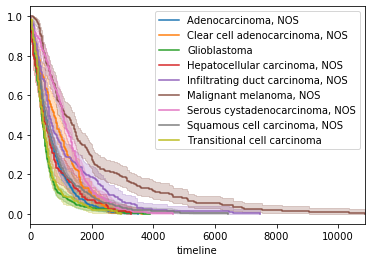

In [4]:
ax = plt.subplot(111)
kmf = KaplanMeierFitter()
for name, grouped_df in df.groupby("primary_diagnosis"):
    kmf.fit(grouped_df["days_to_death"], grouped_df["event_observed"], label=name)
    c = kmf.confidence_interval_survival_function_
    kmf.plot(ax=ax)

In [10]:
df[:100]

,prefix,primary_diagnosis,days_to_death,case_id,event_observed,cluster_id
0,TCGA-CZ-4854,"Clear cell adenocarcinoma, NOS",1404.0,2efcefca-5e52-4b3d-a48a-9e9c73cc0141,1,6
1,TCGA-CZ-5454,"Clear cell adenocarcinoma, NOS",722.0,f2801b21-5444-4cc3-a642-c60c6d82cd3d,1,6
2,TCGA-B0-4844,"Clear cell adenocarcinoma, NOS",313.0,4ee14e95-09d8-4512-b358-3e0e7cb74c9a,1,6
3,TCGA-CJ-6033,"Clear cell adenocarcinoma, NOS",224.0,4edff57f-4b0e-4770-beac-590da7d7232c,1,6
4,TCGA-B6-A0WS,"Infiltrating duct carcinoma, NOS",2965.0,197741de-a098-4f04-bb37-8ea8b3bb39bc,1,5
...,...,...,...,...,...,...
176,TCGA-21-1078,"Squamous cell carcinoma, NOS",474.0,0ab8d063-62b4-4d47-82aa-e3351a60029d,1,1
177,TCGA-60-2696,"Squamous cell carcinoma, NOS",109.0,bff77f70-973a-4b49-8fd9-4a767f5df2c0,1,1
178,TCGA-33-AASB,"Squamous cell carcinoma, NOS",211.0,26556020-3daf-4b8b-a3de-c0532c96aca0,1,1
179,TCGA-77-8133,"Squamous cell carcinoma, NOS",1640.0,becc8bb8-bdbf-426c-b9b6-a23558eb13c1,1,1


In [20]:
_df = df[['days_to_death', 'event_observed', 'cluster_id']]
cph = CoxPHFitter()
cph.fit(_df, 'days_to_death', 'event_observed', cluster_col='cluster_id')
cph.score_

0.5

In [16]:
_df

,days_to_death,event_observed,cluster_id
0,1404.0,1,6
1,722.0,1,6
2,313.0,1,6
3,224.0,1,6
4,2965.0,1,5
5,811.0,1,5
6,2763.0,1,5
7,612.0,1,5
9,678.0,1,5
10,614.0,1,5


In [21]:
df2 = pd.DataFrame({
    'T': [5, 3, 9, 8, 7, 4, 4, 3, 2, 5, 6, 7],
    'E': [1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 0],
    'month': [10, 3, 9, 8, 7, 4, 4, 3, 2, 5, 6, 7],
    'age': [4, 3, 9, 8, 7, 4, 4, 3, 2, 5, 6, 7],
    'id': [1, 1, 1, 1, 2, 3, 3, 4, 4, 5, 6, 7]
})

cph = CoxPHFitter()
cph.fit(df2, 'T', 'E', cluster_col='id')
cph.score_

0.9680851063829787